In [27]:
# Imports for mapping
%matplotlib inline

import os
from os import getenv
import folium
from folium import plugins
import gdal
import numpy.ma as ma
import geopandas as gpd
import rasterio as rio
from rasterio.io import MemoryFile
from rasterio.crs import CRS
from IPython.display import IFrame
import matplotlib.pyplot as plt
#import rioxarray as rxr

basemap_default="Stamen Terrain" # OpenStreetMap Stamen Toner
dst_epsg = 'EPSG:4326'
dst_epsg_crs = CRS.from_string('EPSG:4326')

plot_big_bois = False

In [28]:
####################
# Helper functions #
####################

# A function to transform disk tif to folium compliant data for plotting
def generate_folium_raster_data(in_path, vis_ramp='terrain'):
    """
    Python vis is questionable at best, R is far better
    How to use:
    
    #in_tif_path = os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_meters_'+branch_to_look+'.tif')
    in_tif_path = os.path.join(root_folder,watershed,'branches',branch_to_look,'fol_'+branch_to_look+'.tif')
    fol_ras = generate_folium_raster_data(in_tif_path)

    map= folium.Map(location=fol_ras["center"], zoom_start=7,tiles='Stamen Terrain')
    folium.raster_layers.ImageOverlay(
    name='fol_ras',
        image=fol_ras["array"],
        bounds=fol_ras["bounds"]
    ).add_to(map)
    map
    
    """
    # Load and project data in mem for display
    data = gdal.Open(in_path)
    proj = gdal.osr.SpatialReference(wkt=data.GetProjection())
    data = gdal.Warp("", data, format="vrt", dstSRS='EPSG:4326')
    
    # Get centroid and bounds
    geotransform = data.GetGeoTransform()
    cols = data.RasterXSize 
    rows = data.RasterYSize
    xmin=geotransform[0]
    ymax=geotransform[3]
    xmax=xmin+cols*geotransform[1]
    ymin=ymax+rows*geotransform[5]
    centerx=(xmin+xmax)/2
    centery=(ymin+ymax)/2
    
    # Get layer as array
    band = data.GetRasterBand(1)
    nodata_v= data.GetRasterBand(1).GetNoDataValue()
    data = band.ReadAsArray(0,0,cols,rows)
    
    # Mask no data
    data = ma.masked_where(data == nodata_v, data)

    def colorize(array, vis_ramp):
        normed_data = (array - array.min()) / (array.max() - array.min())    
        cm = plt.cm.get_cmap(vis_ramp)    
        return cm(normed_data) 
    
    data = colorize(data, vis_ramp)
    
    out = dict(); 
    out['array'] = data
    out['center']  = [centery, centerx]
    out['bounds'] = [[ymin, xmin], [ymax, xmax]]
    return out

def generate_folium_vector_data(in_path,outine_color = '#00FF00FF',fill_color='#00FF0000'):
    data = gpd.read_file(in_path)
    data_proj = data.to_crs({'init': dst_epsg})
    data_proj['Outline_RGBA'] = outine_color
    data_proj['fill_RGBA'] = fill_color
    data_json = data_proj.to_json()
    return data_json

In [29]:
# Select a branch to view:
env_file = '/foss_fim/config/params_template.env'
folder_to_place_outputs = 'jimjam_test'
input_folder = '/data/inputs/'
root_folder = f'/data/outputs/{folder_to_place_outputs}/'
watershed = '02020005'

from dotenv import load_dotenv
load_dotenv(dotenv_path=env_file)

if False:
    #gms_run_unit.sh -n {folder_to_place_outputs} -u {watershed} -c /foss_fim/config/params_template.env -j 1 -d /foss_fim/config/keep_all.lst -o -s
    #gms_run_branch.sh -n {folder_to_place_outputs} -c /foss_fim/config/params_template.env  -j 1 -d /foss_fim/config/keep_all.lst -o -s
    print('GMS finished execution')

subfolders = [ f.name for f in os.scandir(f'/data/outputs/{folder_to_place_outputs}/{watershed}/branches') if f.is_dir() ]
print("Valid branch values to look at:")
print(subfolders)

Valid branch values to look at:
['3246000001', '3246000002', '3246000003', '3246000004', '3246000005', '3246000006', '3246000007', '3246000008', '3246000009', '3246000010', '3246000011', '3246000012', '3246000013', '3246000014', '3246000015']


In [30]:
print(
    ' #############################\n',
    '# What are we processing:\n',
    '#############################')

# Select a branch to view:
branch_to_look = '3246000011'

# Generate critical map constents
out_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_meters_'+branch_to_look+'.tif')
fol_ras = generate_folium_raster_data(out_ras)
map_center = fol_ras["center"]

branches = os.path.join(root_folder,watershed,'branch_polygons.gpkg')
branches_data = gpd.read_file(branches)
branches_data = branches_data.to_crs({'init': dst_epsg})
current_branch = branches_data.loc[branches_data['levpa_id']==branch_to_look]

# Set color property and transform for mapping
branches_data['Outline_RGBA'] = '#0000FFFF'
branches_data['fill_RGBA'] = '#00FF0000'
current_branch['Outline_RGBA'] = '#FF0000FF'
current_branch['fill_RGBA'] = '#00FF0000'
branches_data = branches_data.to_json()
current_branch = current_branch.to_json()

# mapping
branch_map = folium.Map(location=map_center, zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(branches_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="All branches").add_to(branch_map)
folium.GeoJson(current_branch,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="Current branch").add_to(branch_map)
branch_map

 #############################
 # What are we processing:
 #############################


In [ ]:
# $srcDir/gms/clip_rasters_to_branches.py 
#-d $current_branch_id 
#-b $outputHucDataDir/branch_polygons.gpkg 
#-i $branch_id_attribute 
#-r $input_DEM 
#-c $outputCurrentBranchDataDir/dem_meters.tif 
#-v 
print(' ########################################################################## \n',
      f'Clipping rasters to branches {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

# Inputs
branches = os.path.join(root_folder,watershed,'branch_polygons.gpkg')
in_ras = os.path.join(input_folder,'nhdplus_rasters','HRNHDPlusRasters'+watershed[0:4],'elev_m.tif')
out_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_meters_'+branch_to_look+'.tif')

if plot_big_bois:
    print(
        ' #############################\n',
        '# What the input looks like:\n',
        '#############################')
    branches_data = gpd.read_file(branches)

    print('branches geopackage:')
    print(branches_data.head())
    print("")

    branches_data = branches_data.to_crs({'init': dst_epsg})
    current_branch = branches_data
    branches_data = branches_data.to_json()

    fol_ras = generate_folium_raster_data(in_ras)
    input_map = folium.Map(location=fol_ras["center"], zoom_start=7,tiles='Stamen Terrain')
    folium.raster_layers.ImageOverlay(
        image=fol_ras["array"],
        bounds=fol_ras["bounds"]
    ).add_to(input_map)
    folium.GeoJson(branches_data, name="geojson").add_to(input_map)
    input_map

print(
    ' #############################\n',
    '# What the output looks like:\n',
    '#############################')

fol_ras = generate_folium_raster_data(out_ras)
output_map = folium.Map(location=fol_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(current_branch,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="Current branch").add_to(output_map)
folium.raster_layers.ImageOverlay(
    image=fol_ras["array"],
    bounds=fol_ras["bounds"]
).add_to(output_map)
output_map


In [ ]:
print(' ########################################################################## \n',
      f'Subsetting vectors to branches {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

print(
    ' #############################\n',
    '# What the output looks like:\n',
    '#############################')

# Inputs
catchments = os.path.join(root_folder,watershed,'nwm_catchments_proj_subset_levelPaths.gpkg')
streams = os.path.join(root_folder,watershed,'nwm_subset_streams_levelPaths.gpkg')
headwaters = os.path.join(root_folder,watershed,'nwm_subset_streams_levelPaths_dissolved_headwaters.gpkg')

catchments_data = generate_folium_vector_data(catchments,'#0000FFFF','#00FF0000')
streams_data = generate_folium_vector_data(streams,'#FF0000FF','#00FF0000')
headwaters_data = generate_folium_vector_data(headwaters,'#FF0000FF','#00FF0000')

cutting_vector_map = folium.Map(location=map_center, zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(catchments_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="All branches").add_to(cutting_vector_map)
folium.GeoJson(streams_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="Current branch").add_to(cutting_vector_map)
folium.GeoJson(headwaters_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="Current branch").add_to(cutting_vector_map)
cutting_vector_map


In [ ]:
print(' ########################################################################## \n',
      f'Rasterize all NLD multilines using zelev vertices {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

print(
    ' #############################\n',
    '# What the output looks like:\n',
    '#############################')

print(' \n ### ALERT: Raster could be empty (comment note:# REMAINS UNTESTED FOR AREAS WITH LEVEES)')
nld_rasterized_elev_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'nld_rasterized_elev_'+branch_to_look+'.tif'))

nld_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'nld_subset_levees.gpkg'),
                                       '#FF0000FF','#00FF0000')

rasterize_nld_map = folium.Map(location=nld_rasterized_elev_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(nld_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="Current branch").add_to(rasterize_nld_map)
folium.raster_layers.ImageOverlay(
    names="nld_rasterized_elev_ras",
    image=nld_rasterized_elev_ras["array"],
    bounds=nld_rasterized_elev_ras["bounds"]
).add_to(rasterize_nld_map)
folium.LayerControl().add_to(rasterize_nld_map)
rasterize_nld_map


In [ ]:
print(' ########################################################################## \n',
      f'Rasterize Reach Boolean {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

print(
    ' #############################\n',
    '# What the output looks like:\n',
    '#############################')

flows_grid_boolean_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'flows_grid_boolean_'+branch_to_look+'.tif'), 
    'Reds')

reach_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'nwm_subset_streams_levelPaths_'+branch_to_look+'.gpkg'),
                                         '#00FF00FF','#00FF0000')

rasterize_reach_map = folium.Map(location=fol_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(reach_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="Current branch").add_to(rasterize_reach_map)
folium.raster_layers.ImageOverlay(
    name='test',
    image=flows_grid_boolean_ras["array"],
    bounds=flows_grid_boolean_ras["bounds"]
).add_to(rasterize_reach_map)
folium.LayerControl().add_to(rasterize_reach_map)
rasterize_reach_map

In [ ]:
print(' ########################################################################## \n',
      f'Rasterize NHD Headwaters {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

print(
    ' #############################\n',
    '# What the output looks like:\n',
    '#############################')

headwaters_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'headwaters_'+branch_to_look+'.tif'))

heads_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'nwm_subset_streams_levelPaths_dissolved_headwaters_'+branch_to_look+'.gpkg'),
                                         '#00FF00FF','#00FF0000')

rasterize_head_map = folium.Map(location=headwaters_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(heads_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="Current branch").add_to(rasterize_head_map)
folium.raster_layers.ImageOverlay(
    name='headwaters_ras',
    image=headwaters_ras["array"],
    bounds=headwaters_ras["bounds"]
).add_to(rasterize_head_map)
folium.LayerControl().add_to(rasterize_head_map)
rasterize_head_map

In [ ]:
#$srcDir/burn_in_levees.py 
#-dem $outputCurrentBranchDataDir/dem_meters_$current_branch_id.tif 
#-nld $outputCurrentBranchDataDir/nld_rasterized_elev_$current_branch_id.tif 
#-out $outputCurrentBranchDataDir/dem_meters_$current_branch_id.tif
print(' ########################################################################## \n',
      f'Burn nld levees into dem & convert nld elev to meters (*Overwrite dem_meters.tif output) {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

nld_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'nld_rasterized_elev_'+branch_to_look+'.tif')) 
burn_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_meters_'+branch_to_look+'.tif'))

burn_nld_map = folium.Map(location=nld_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    name='nld_ras',
    image=nld_ras["array"],
    bounds=nld_ras["bounds"]
).add_to(burn_nld_map)
folium.raster_layers.ImageOverlay(
    name='',
    image=burn_ras["array"],
    bounds=burn_ras["bounds"]
).add_to(burn_nld_map)
folium.LayerControl().add_to(burn_nld_map)
burn_nld_map


In [ ]:
nld_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'nld_rasterized_elev_'+branch_to_look+'.tif')) 
burn_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_meters_'+branch_to_look+'.tif'))
nld_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'nld_subset_levees.gpkg'),
                                       '#FF0000FF','#00FF0000')
#nld_rasterized_elev_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'nld_rasterized_elev_'+branch_to_look+'.tif'))

burn_nld_map = folium.Map(location=nld_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(nld_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="Current branch").add_to(burn_nld_map)
folium.raster_layers.ImageOverlay(
    name='nld_ras',
    image=nld_ras["array"],
    bounds=nld_ras["bounds"]
).add_to(burn_nld_map)
folium.raster_layers.ImageOverlay(
    name='nld_ras',
    image=nld_ras["array"],
    bounds=nld_ras["bounds"]
).add_to(burn_nld_map)
folium.raster_layers.ImageOverlay(
    name='',
    image=burn_ras["array"],
    bounds=burn_ras["bounds"]
).add_to(burn_nld_map)
folium.LayerControl().add_to(burn_nld_map)
burn_nld_map


In [ ]:
#$srcDir/agreedem.py 
#-r $outputCurrentBranchDataDir/flows_grid_boolean_$current_branch_id.tif 
#-d $outputCurrentBranchDataDir/dem_meters_$current_branch_id.tif 
#-w $outputCurrentBranchDataDir 
#-g $outputCurrentBranchDataDir/temp_work 
#-o $outputCurrentBranchDataDir/dem_burned_$current_branch_id.tif 
#-b $agree_DEM_buffer 
#-sm 10 
#-sh 1000
agree_buffer = int(getenv("agree_DEM_buffer"))
print(' ########################################################################## \n',
      f'Creating AGREE DEM using {agree_buffer} meter buffer {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

flows_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'flows_grid_boolean_'+branch_to_look+'.tif'), 'Reds')
burn_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_burned_'+branch_to_look+'.tif'))

AGREE_DEM_map = folium.Map(location=burn_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    name='flows',
    image=flows_ras["array"],
    bounds=flows_ras["bounds"]
).add_to(AGREE_DEM_map)
folium.raster_layers.ImageOverlay(
    name='burn_ras',
    image=burn_ras["array"],
    bounds=burn_ras["bounds"]
).add_to(AGREE_DEM_map)
folium.LayerControl().add_to(AGREE_DEM_map)
AGREE_DEM_map

In [ ]:
#rd_depression_filling 
#$outputCurrentBranchDataDir/dem_burned_$current_branch_id.tif 
#$outputCurrentBranchDataDir/dem_burned_filled_$current_branch_id.tif
print(' ########################################################################## \n',
      f'Pit remove Burned DEM {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

burn_fill_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_burned_filled_'+branch_to_look+'.tif'))

depression_filling_map = folium.Map(location=burn_fill_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    image=burn_fill_ras["array"],
    bounds=burn_fill_ras["bounds"]
).add_to(depression_filling_map)
folium.LayerControl().add_to(depression_filling_map)
depression_filling_map

In [ ]:
#$taudemDir2/d8flowdir 
#-fel $outputCurrentBranchDataDir/dem_burned_filled_$current_branch_id.tif 
#-p $outputCurrentBranchDataDir/flowdir_d8_burned_filled_$current_branch_id.tif
#$taudemDir/aread8 
#-p $outputCurrentBranchDataDir/flowdir_d8_burned_filled_$current_branch_id.tif 
#-ad8  $outputCurrentBranchDataDir/flowaccum_d8_burned_filled_$current_branch_id.tif 
#-wg  $outputCurrentBranchDataDir/headwaters_$current_branch_id.tif 
#-nc
print(' ########################################################################## \n',
      f'D8 Flow Direction and accumulation on Burned DEM {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

burn_fill_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_burned_filled_'+branch_to_look+'.tif'))
D8_flowdir_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'flowdir_d8_burned_filled_'+branch_to_look+'.tif'),'hsv')
D8_flowacc_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'flowaccum_d8_burned_filled_'+branch_to_look+'.tif'),'cool')

D8_flow_map = folium.Map(location=burn_fill_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    name='burn_fill_ras',
    image=burn_fill_ras["array"],
    bounds=burn_fill_ras["bounds"]
).add_to(D8_flow_map)
folium.raster_layers.ImageOverlay(
    name="D8_flowdir_ras",
    image=D8_flowdir_ras["array"],
    bounds=D8_flowdir_ras["bounds"]
).add_to(D8_flow_map)
folium.raster_layers.ImageOverlay(
    name='D8_flowacc_ras',
    image=D8_flowacc_ras["array"],
    bounds=D8_flowacc_ras["bounds"]
).add_to(D8_flow_map)
folium.LayerControl().add_to(D8_flow_map)
D8_flow_map

In [ ]:
#$taudemDir/threshold 
#-ssa $outputCurrentBranchDataDir/flowaccum_d8_burned_filled_$current_branch_id.tif 
#-src  $outputCurrentBranchDataDir/demDerived_streamPixels_$current_branch_id.tif 
#-thresh 1
print(' ########################################################################## \n',
      f'Threshold Accumulations {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

stream_pix_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_streamPixels_'+branch_to_look+'.tif')
stream_pix_ras = generate_folium_raster_data(stream_pix_ras)
D8_flowacc_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'flowaccum_d8_burned_filled_'+branch_to_look+'.tif')
D8_flowacc_ras = generate_folium_raster_data(D8_flowacc_ras,'cool')

thresh_accum_map = folium.Map(location=stream_pix_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    image=stream_pix_ras["array"],
    bounds=stream_pix_ras["bounds"]
).add_to(thresh_accum_map)
folium.raster_layers.ImageOverlay(
    image=D8_flowacc_ras["array"],
    bounds=D8_flowacc_ras["bounds"]
).add_to(thresh_accum_map)
folium.LayerControl().add_to(thresh_accum_map)
thresh_accum_map

In [ ]:
#$srcDir/unique_pixel_and_allocation.py 
#-s $outputCurrentBranchDataDir/demDerived_streamPixels_$current_branch_id.tif 
#-o $outputCurrentBranchDataDir/demDerived_streamPixels_ids_$current_branch_id.tif 
#-g $outputCurrentBranchDataDir/temp_grass
print(' ########################################################################## \n',
      f'Preprocessing for lateral thalweg adjustment {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

stream_pix_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_streamPixels_'+branch_to_look+'.tif')
stream_pix_ras = generate_folium_raster_data(stream_pix_ras)
stream_pix_ID_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_streamPixels_ids_'+branch_to_look+'.tif')
stream_pix_ID_ras = generate_folium_raster_data(stream_pix_ID_ras,'cool')

prepro_lat_thal_adj_map = folium.Map(location=stream_pix_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    image=stream_pix_ras["array"],
    bounds=stream_pix_ras["bounds"]
).add_to(prepro_lat_thal_adj_map)
folium.raster_layers.ImageOverlay(
    image=stream_pix_ID_ras["array"],
    bounds=stream_pix_ID_ras["bounds"]
).add_to(prepro_lat_thal_adj_map)
folium.LayerControl().add_to(prepro_lat_thal_adj_map)
prepro_lat_thal_adj_map


In [ ]:
#$srcDir/adjust_thalweg_lateral.py 
#-e $outputCurrentBranchDataDir/dem_meters_$current_branch_id.tif 
#-s $outputCurrentBranchDataDir/demDerived_streamPixels_$current_branch_id.tif 
#-a $outputCurrentBranchDataDir/demDerived_streamPixels_ids_"$current_branch_id"_allo.tif 
#-d $outputCurrentBranchDataDir/demDerived_streamPixels_ids_"$current_branch_id"_dist.tif 
#-t 50 -o $outputCurrentBranchDataDir/dem_lateral_thalweg_adj_$current_branch_id.tif 
#-th $thalweg_lateral_elev_threshold
print(' ########################################################################## \n',
      f'Performing lateral thalweg adjustment {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

stream_pix_ID_allo_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,
                                      'demDerived_streamPixels_ids_'+branch_to_look+'_allo.tif')
stream_pix_ID_allo_ras = generate_folium_raster_data(stream_pix_ID_allo_ras)
stream_pix_ID_dist_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,
                                      'demDerived_streamPixels_ids_'+branch_to_look+'_dist.tif')
stream_pix_ID_dist_ras = generate_folium_raster_data(stream_pix_ID_dist_ras)
DEM_thal_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_lateral_thalweg_adj_'+branch_to_look+'.tif')
DEM_thal_ras = generate_folium_raster_data(DEM_thal_ras)

DEM_thal_map = folium.Map(location=DEM_thal_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    name='dem_lateral_thalweg_adj',
    image=DEM_thal_ras["array"],
    bounds=DEM_thal_ras["bounds"]
).add_to(DEM_thal_map)
folium.LayerControl().add_to(DEM_thal_map)
DEM_thal_map

In [ ]:
print(' ########################################################################## \n',
      f'Mask Burned DEM for Thalweg Only {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

flowdir_d8_burned_filled_flows_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'flowdir_d8_burned_filled_flows_'+branch_to_look+'.tif')
flowdir_d8_burned_filled_flows_ras = generate_folium_raster_data(flowdir_d8_burned_filled_flows_ras)

DEM_thal_map = folium.Map(location=flowdir_d8_burned_filled_flows_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    name='flowdir_d8_burned_filled_flows_ras',
    image=flowdir_d8_burned_filled_flows_ras["array"],
    bounds=flowdir_d8_burned_filled_flows_ras["bounds"]
).add_to(DEM_thal_map)
folium.LayerControl().add_to(DEM_thal_map)
DEM_thal_map

In [ ]:
#$taudemDir/flowdircond 
#-p $outputCurrentBranchDataDir/flowdir_d8_burned_filled_flows_$current_branch_id.tif 
#-z $outputCurrentBranchDataDir/dem_lateral_thalweg_adj_$current_branch_id.tif 
#-zfdc $outputCurrentBranchDataDir/dem_thalwegCond_$current_branch_id.tif
print(' ########################################################################## \n',
      f'Flow Condition Thalweg {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

flowdir_d8_burned_filled_flows_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'flowdir_d8_burned_filled_flows_'+branch_to_look+'.tif')
flowdir_d8_burned_filled_flows_ras = generate_folium_raster_data(flowdir_d8_burned_filled_flows_ras)
DEM_thal_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_lateral_thalweg_adj_'+branch_to_look+'.tif')
DEM_thal_ras = generate_folium_raster_data(DEM_thal_ras)
DEM_thal_cond_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_thalwegCond_'+branch_to_look+'.tif')
DEM_thal_cond_ras = generate_folium_raster_data(DEM_thal_cond_ras)

DEM_thal_map = folium.Map(location=flowdir_d8_burned_filled_flows_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    name='flowdir_d8_burned_filled_flows_ras',
    image=flowdir_d8_burned_filled_flows_ras["array"],
    bounds=flowdir_d8_burned_filled_flows_ras["bounds"]
).add_to(DEM_thal_map)
folium.raster_layers.ImageOverlay(
    name='dem_lateral_thalweg_adj_ras',
    image=DEM_thal_ras["array"],
    bounds=DEM_thal_ras["bounds"]
).add_to(DEM_thal_map)
folium.raster_layers.ImageOverlay(
    name='dem_thalweg_cond',
    image=DEM_thal_cond_ras["array"],
    bounds=DEM_thal_cond_ras["bounds"]
).add_to(DEM_thal_map)
folium.LayerControl().add_to(DEM_thal_map)
DEM_thal_map

In [ ]:
#$taudemDir2/d8flowdir 
#-fel $outputCurrentBranchDataDir/dem_lateral_thalweg_adj_$current_branch_id.tif 
#-sd8 $outputCurrentBranchDataDir/slopes_d8_dem_meters_$current_branch_id.tif
print(' ########################################################################## \n',
      f'D8 Slopes from DEM {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

slopes_D8_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'slopes_d8_dem_meters_'+branch_to_look+'.tif')
slopes_D8_ras = generate_folium_raster_data(slopes_D8_ras)
DEM_thal_cond_ras = os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_thalwegCond_'+branch_to_look+'.tif')
DEM_thal_cond_ras = generate_folium_raster_data(DEM_thal_cond_ras)

D8_slope_map = folium.Map(location=slopes_D8_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    name='slopes_D8_ras',
    image=slopes_D8_ras["array"],
    bounds=slopes_D8_ras["bounds"]
).add_to(D8_slope_map)
folium.raster_layers.ImageOverlay(
    name='dem_thalweg_cond',
    image=DEM_thal_cond_ras["array"],
    bounds=DEM_thal_cond_ras["bounds"]
).add_to(D8_slope_map)
folium.LayerControl().add_to(D8_slope_map)
D8_slope_map

In [ ]:
#$taudemDir/streamnet 
#-p $outputCurrentBranchDataDir/flowdir_d8_burned_filled_$current_branch_id.tif 
#-fel $outputCurrentBranchDataDir/dem_thalwegCond_$current_branch_id.tif 
#-ad8 $outputCurrentBranchDataDir/flowaccum_d8_burned_filled_$current_branch_id.tif 
#-src $outputCurrentBranchDataDir/demDerived_streamPixels_$current_branch_id.tif 
#-ord $outputCurrentBranchDataDir/streamOrder_$current_branch_id.tif 
#-tree $outputCurrentBranchDataDir/treeFile_$current_branch_id.txt 
#-coord $outputCurrentBranchDataDir/coordFile_$current_branch_id.txt 
#-w $outputCurrentBranchDataDir/sn_catchments_reaches_$current_branch_id.tif 
#-net $outputCurrentBranchDataDir/demDerived_reaches_$current_branch_id.shp
print(' ########################################################################## \n',
      f'Stream Net for Reaches {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

flowdir_d8_burned_filled_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'flowdir_d8_burned_filled_'+branch_to_look+'.tif'))
dem_thalwegCond_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_thalwegCond_'+branch_to_look+'.tif'))
flowaccum_d8_burned_filled_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'flowaccum_d8_burned_filled_'+branch_to_look+'.tif'))
demDerived_streamPixels_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_streamPixels_'+branch_to_look+'.tif'))
streamOrder_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'streamOrder_'+branch_to_look+'.tif'))
sn_catchments_reaches_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'sn_catchments_reaches_'+branch_to_look+'.tif'),
    'Reds')

demDerived_reaches_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_reaches_'+branch_to_look+'.shp'),
                                                      '#00FF00FF','#00FF0000')

stream_net_map = folium.Map(location=sn_catchments_reaches_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(demDerived_reaches_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="reaches").add_to(stream_net_map)
folium.raster_layers.ImageOverlay(
    name='sn_catchments_reaches_ras',
    image=sn_catchments_reaches_ras["array"],
    bounds=sn_catchments_reaches_ras["bounds"]
).add_to(stream_net_map)
folium.LayerControl().add_to(stream_net_map)
stream_net_map

In [ ]:
# $srcDir/split_flows.py 
# -f $outputCurrentBranchDataDir/demDerived_reaches_$current_branch_id.shp 
# -d $outputCurrentBranchDataDir/dem_thalwegCond_$current_branch_id.tif 
# -s $outputCurrentBranchDataDir/demDerived_reaches_split_$current_branch_id.gpkg 
# -p $outputCurrentBranchDataDir/demDerived_reaches_split_points_$current_branch_id.gpkg 
# -w $outputHucDataDir/wbd8_clp.gpkg 
# -l $outputHucDataDir/nwm_lakes_proj_subset.gpkg 
# -ds $dropLowStreamOrders
print(' ########################################################################## \n',
      f'Split Derived Reaches {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

dem_thalwegCond_ras = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'dem_thalwegCond_'+branch_to_look+'.tif'))

demDerived_reaches_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_reaches_'+branch_to_look+'.shp'),
                                                      '#00FF00FF','#00FF0000')
demDerived_reaches_split_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_reaches_split_'+branch_to_look+'.gpkg'),
                                                            '#00FF00FF','#00FF0000')
demDerived_reaches_split_points_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_reaches_split_points_'+branch_to_look+'.gpkg'),
                                                                   '#00FF00FF','#00FF0000')
wbd8_clp_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'wbd8_clp.gpkg'),
                                            '#00FF00FF','#00FF0000')
nwm_lakes_proj_subset_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'nwm_lakes_proj_subset.gpkg'),
                                                         '#00FF00FF','#00FF0000')

split_derived_reaches_map = folium.Map(location=dem_thalwegCond_ras["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(demDerived_reaches_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="demDerived_reaches_data").add_to(split_derived_reaches_map)
folium.GeoJson(demDerived_reaches_split_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="demDerived_reaches_split_data").add_to(split_derived_reaches_map)
if plot_big_bois:
    folium.GeoJson(demDerived_reaches_split_points_data,
                   style_function=lambda feature: {
                       'fillColor': feature['properties']['fill_RGBA'],
                       'color' : feature['properties']['Outline_RGBA'],
                       'weight' : 1,'fillOpacity' : 0.5},
                   name="demDerived_reaches_split_points_data").add_to(split_derived_reaches_map)
folium.GeoJson(wbd8_clp_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="wbd8_clp_data").add_to(split_derived_reaches_map)
folium.GeoJson(nwm_lakes_proj_subset_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="nwm_lakes_proj_subset_data").add_to(split_derived_reaches_map)
folium.raster_layers.ImageOverlay(
    name='dem_thalwegCond_ras',
    image=dem_thalwegCond_ras["array"],
    bounds=dem_thalwegCond_ras["bounds"]
).add_to(split_derived_reaches_map)
folium.LayerControl().add_to(split_derived_reaches_map)
split_derived_reaches_map

In [ ]:
#$taudemDir/gagewatershed 
#-p $outputCurrentBranchDataDir/flowdir_d8_burned_filled_$current_branch_id.tif 
#-gw $outputCurrentBranchDataDir/gw_catchments_reaches_$current_branch_id.tif 
#-o $outputCurrentBranchDataDir/demDerived_reaches_split_points_$current_branch_id.gpkg 
#-id $outputCurrentBranchDataDir/idFile_$current_branch_id.txt
print(' ########################################################################## \n',
      f'Gage Watershed for Reaches {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

flowdir_d8_burned_filled_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'flowdir_d8_burned_filled_'+branch_to_look+'.tif'))
gw_catchments_reaches_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_'+branch_to_look+'.tif'))

demDerived_reaches_split_points_data = generate_folium_vector_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_reaches_split_points_'+branch_to_look+'.gpkg'),
                                                         '#00FF00FF','#00FF0000')

gage_watershed_map = folium.Map(location=flowdir_d8_burned_filled_ras["center"], zoom_start=9,tiles='Stamen Terrain')
if plot_big_bois:
    folium.GeoJson(demDerived_reaches_split_points_data,
                   style_function=lambda feature: {
                       'fillColor': feature['properties']['fill_RGBA'],
                       'color' : feature['properties']['Outline_RGBA'],
                       'weight' : 1,'fillOpacity' : 0.5},
                   name="demDerived_reaches_split_points_data").add_to(gage_watershed_map)
folium.raster_layers.ImageOverlay(
    name='flowdir_d8_burned_filled_ras',
    image=flowdir_d8_burned_filled_ras["array"],
    bounds=flowdir_d8_burned_filled_ras["bounds"]
).add_to(gage_watershed_map)
folium.raster_layers.ImageOverlay(
    name='gw_catchments_reaches_ras',
    image=gw_catchments_reaches_ras["array"],
    bounds=gw_catchments_reaches_ras["bounds"]
).add_to(gage_watershed_map)
folium.LayerControl().add_to(gage_watershed_map)
gage_watershed_map

In [ ]:
#$srcDir/reachID_grid_to_vector_points.py 
#-r $outputCurrentBranchDataDir/demDerived_streamPixels_$current_branch_id.tif 
#-i featureID 
#-p $outputCurrentBranchDataDir/flows_points_pixels_$current_branch_id.gpkg
print(' ########################################################################## \n',
      f'Vectorize Pixel Centroids {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

demDerived_streamPixels_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_streamPixels_'+branch_to_look+'.tif'))

gw_catchments_reaches_data = generate_folium_vector_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_'+branch_to_look+'.gpkg'),
    '#00FF00FF','#00FF0000')

vectorize_pixel_centroids_map = folium.Map(location=demDerived_streamPixels_ras["center"], zoom_start=9,tiles='Stamen Terrain')
if plot_big_bois:
    folium.GeoJson(gw_catchments_reaches_data,
                   style_function=lambda feature: {
                       'fillColor': feature['properties']['fill_RGBA'],
                       'color' : feature['properties']['Outline_RGBA'],
                       'weight' : 1,'fillOpacity' : 0.5},
                   name="flows_points_pixels_data").add_to(vectorize_pixel_centroids_map)
folium.raster_layers.ImageOverlay(
    name='demDerived_streamPixels_ras',
    image=demDerived_streamPixels_ras["array"],
    bounds=demDerived_streamPixels_ras["bounds"]
).add_to(vectorize_pixel_centroids_map)
folium.LayerControl().add_to(vectorize_pixel_centroids_map)
vectorize_pixel_centroids_map

In [ ]:
#$taudemDir/gagewatershed 
#-p $outputCurrentBranchDataDir/flowdir_d8_burned_filled_"$current_branch_id".tif 
#-gw $outputCurrentBranchDataDir/gw_catchments_pixels_$current_branch_id.tif 
#-o $outputCurrentBranchDataDir/flows_points_pixels_$current_branch_id.gpkg 
#-id $outputCurrentBranchDataDir/idFile_$current_branch_id.txt
print(' ########################################################################## \n',
      f'Gage Watershed for Pixels {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

flowdir_d8_burned_filled_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'flowdir_d8_burned_filled_'+branch_to_look+'.tif'))
gw_catchments_reaches_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_pixels_'+branch_to_look+'.tif'))

flows_points_pixels_data = generate_folium_vector_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'flows_points_pixels_'+branch_to_look+'.gpkg'),
    '#00FF00FF','#00FF0000')

gage_watershed_map = folium.Map(location=flowdir_d8_burned_filled_ras["center"], zoom_start=9,tiles='Stamen Terrain')
if plot_big_bois:
    folium.GeoJson(flows_points_pixels_data,
                   style_function=lambda feature: {
                       'fillColor': feature['properties']['fill_RGBA'],
                       'color' : feature['properties']['Outline_RGBA'],
                       'weight' : 1,'fillOpacity' : 0.5},
                   name="flows_points_pixels_data").add_to(gage_watershed_map)
folium.raster_layers.ImageOverlay(
    name='flowdir_d8_burned_filled_ras',
    image=flowdir_d8_burned_filled_ras["array"],
    bounds=flowdir_d8_burned_filled_ras["bounds"]
).add_to(gage_watershed_map)
folium.raster_layers.ImageOverlay(
    name='gw_catchments_reaches_ras',
    image=gw_catchments_reaches_ras["array"],
    bounds=gw_catchments_reaches_ras["bounds"]
).add_to(gage_watershed_map)
folium.LayerControl().add_to(gage_watershed_map)
gage_watershed_map

In [ ]:
#srcDir/gms/rem.py 
#-d $outputCurrentBranchDataDir/dem_thalwegCond_"$current_branch_id".tif 
#-w $outputCurrentBranchDataDir/gw_catchments_pixels_$current_branch_id.tif 
#-o $outputCurrentBranchDataDir/rem_$current_branch_id.tif 
#-t $outputCurrentBranchDataDir/demDerived_streamPixels_$current_branch_id.tif
print(' ########################################################################## \n',
      f'D8 REM {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

flowdir_d8_burned_filled_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'flowdir_d8_burned_filled_'+branch_to_look+'.tif'))
gw_catchments_pixels_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_pixels_'+branch_to_look+'.tif'))

demDerived_reaches_split_points_data = generate_folium_vector_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_reaches_split_points_'+branch_to_look+'.gpkg'),
    '#00FF00FF','#00FF0000')

gage_watershed_map = folium.Map(location=flowdir_d8_burned_filled_ras["center"], zoom_start=9,tiles='Stamen Terrain')
if plot_big_bois:
    folium.GeoJson(demDerived_reaches_split_points_data,
                   style_function=lambda feature: {
                       'fillColor': feature['properties']['fill_RGBA'],
                       'color' : feature['properties']['Outline_RGBA'],
                       'weight' : 1,'fillOpacity' : 0.5},
                   name="flows_points_pixels_data").add_to(gage_watershed_map)
folium.raster_layers.ImageOverlay(
    name='flowdir_d8_burned_filled_ras',
    image=flowdir_d8_burned_filled_ras["array"],
    bounds=flowdir_d8_burned_filled_ras["bounds"]
).add_to(gage_watershed_map)
folium.raster_layers.ImageOverlay(
    name='gw_catchments_pixels_ras',
    image=gw_catchments_pixels_ras["array"],
    bounds=gw_catchments_pixels_ras["bounds"]
).add_to(gage_watershed_map)
folium.LayerControl().add_to(gage_watershed_map)
gage_watershed_map

In [ ]:
print(' ########################################################################## \n',
      f'Bring negative values in REM to zero and mask to catchments {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

REM_mask = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'rem_zeroed_masked_'+branch_to_look+'.tif'))

REM_mask_map = folium.Map(location=REM_mask["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    name='REM_mask',
    image=REM_mask["array"],
    bounds=REM_mask["bounds"]
).add_to(REM_mask_map)
folium.LayerControl().add_to(REM_mask_map)
REM_mask_map

In [ ]:
#if [ -f $outputHucDataDir/LandSea_subset.gpkg ]; then
#    gdal_rasterize -ot Int32 -burn $ndv -a_nodata $ndv -init 1 -co 
#    "COMPRESS=LZW" -co "BIGTIFF=YES" -co "TILED=YES" -te $xmin
#    $ymin $xmax $ymax -ts $ncols $nrows 
#    $outputHucDataDir/LandSea_subset.gpkg 
#    $outputCurrentBranchDataDir/LandSea_subset_$current_branch_id.tif
#    Tcount
#fi
print(' ########################################################################## \n',
      f'Rasterize filtered/dissolved ocean/Glake polygon {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')



 ########################################################################## 
 Polygonize Reach Watersheds 02020005 3246000011
 ##########################################################################  




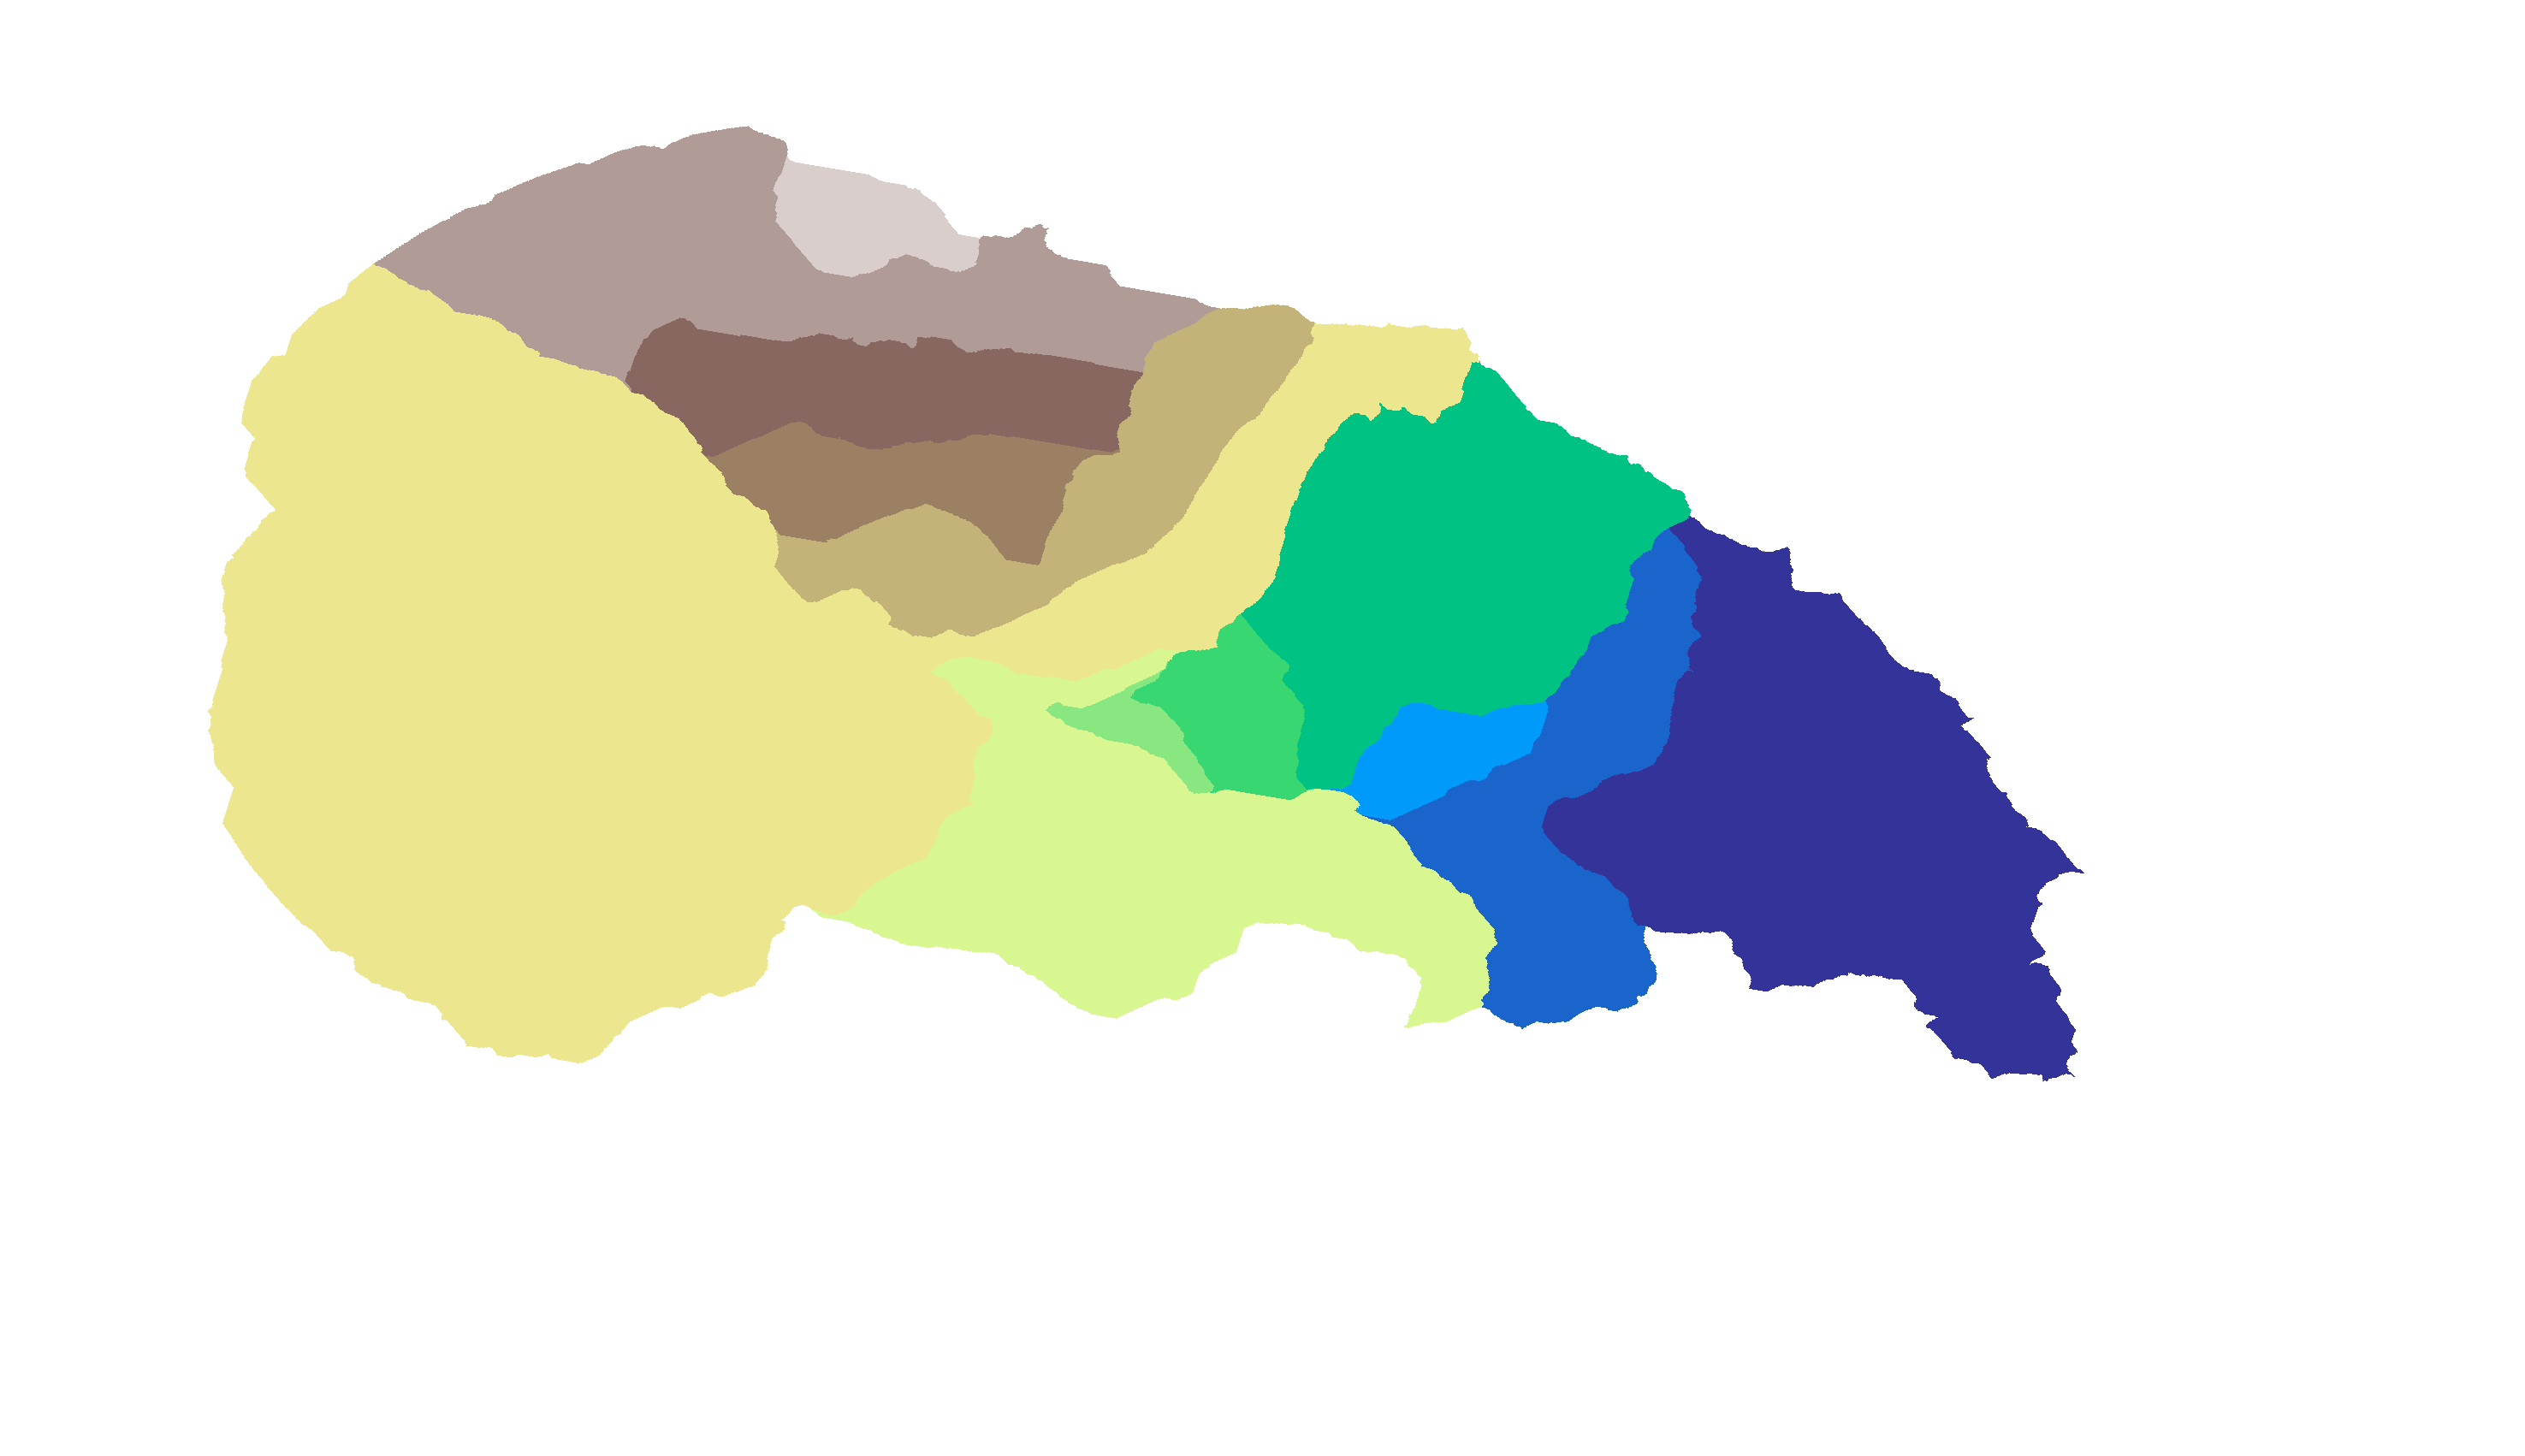

In [31]:
print(' ########################################################################## \n',
      f'Polygonize Reach Watersheds {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

gw_catchments_reaches = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_'+branch_to_look+'.tif'))

gw_catchments_reaches_data = generate_folium_vector_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_'+branch_to_look+'.gpkg'),
    '#00FF00FF','#00FF0000')

gw_catchments_reaches_map = folium.Map(location=gw_catchments_reaches["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(gw_catchments_reaches_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="gw_catchments_reaches_data").add_to(gw_catchments_reaches_map)
folium.raster_layers.ImageOverlay(
    name='gw_catchments_reaches',
    image=gw_catchments_reaches["array"],
    bounds=gw_catchments_reaches["bounds"]
).add_to(gw_catchments_reaches_map)
folium.LayerControl().add_to(gw_catchments_reaches_map)
gw_catchments_reaches_map

In [ ]:
##### DEV below


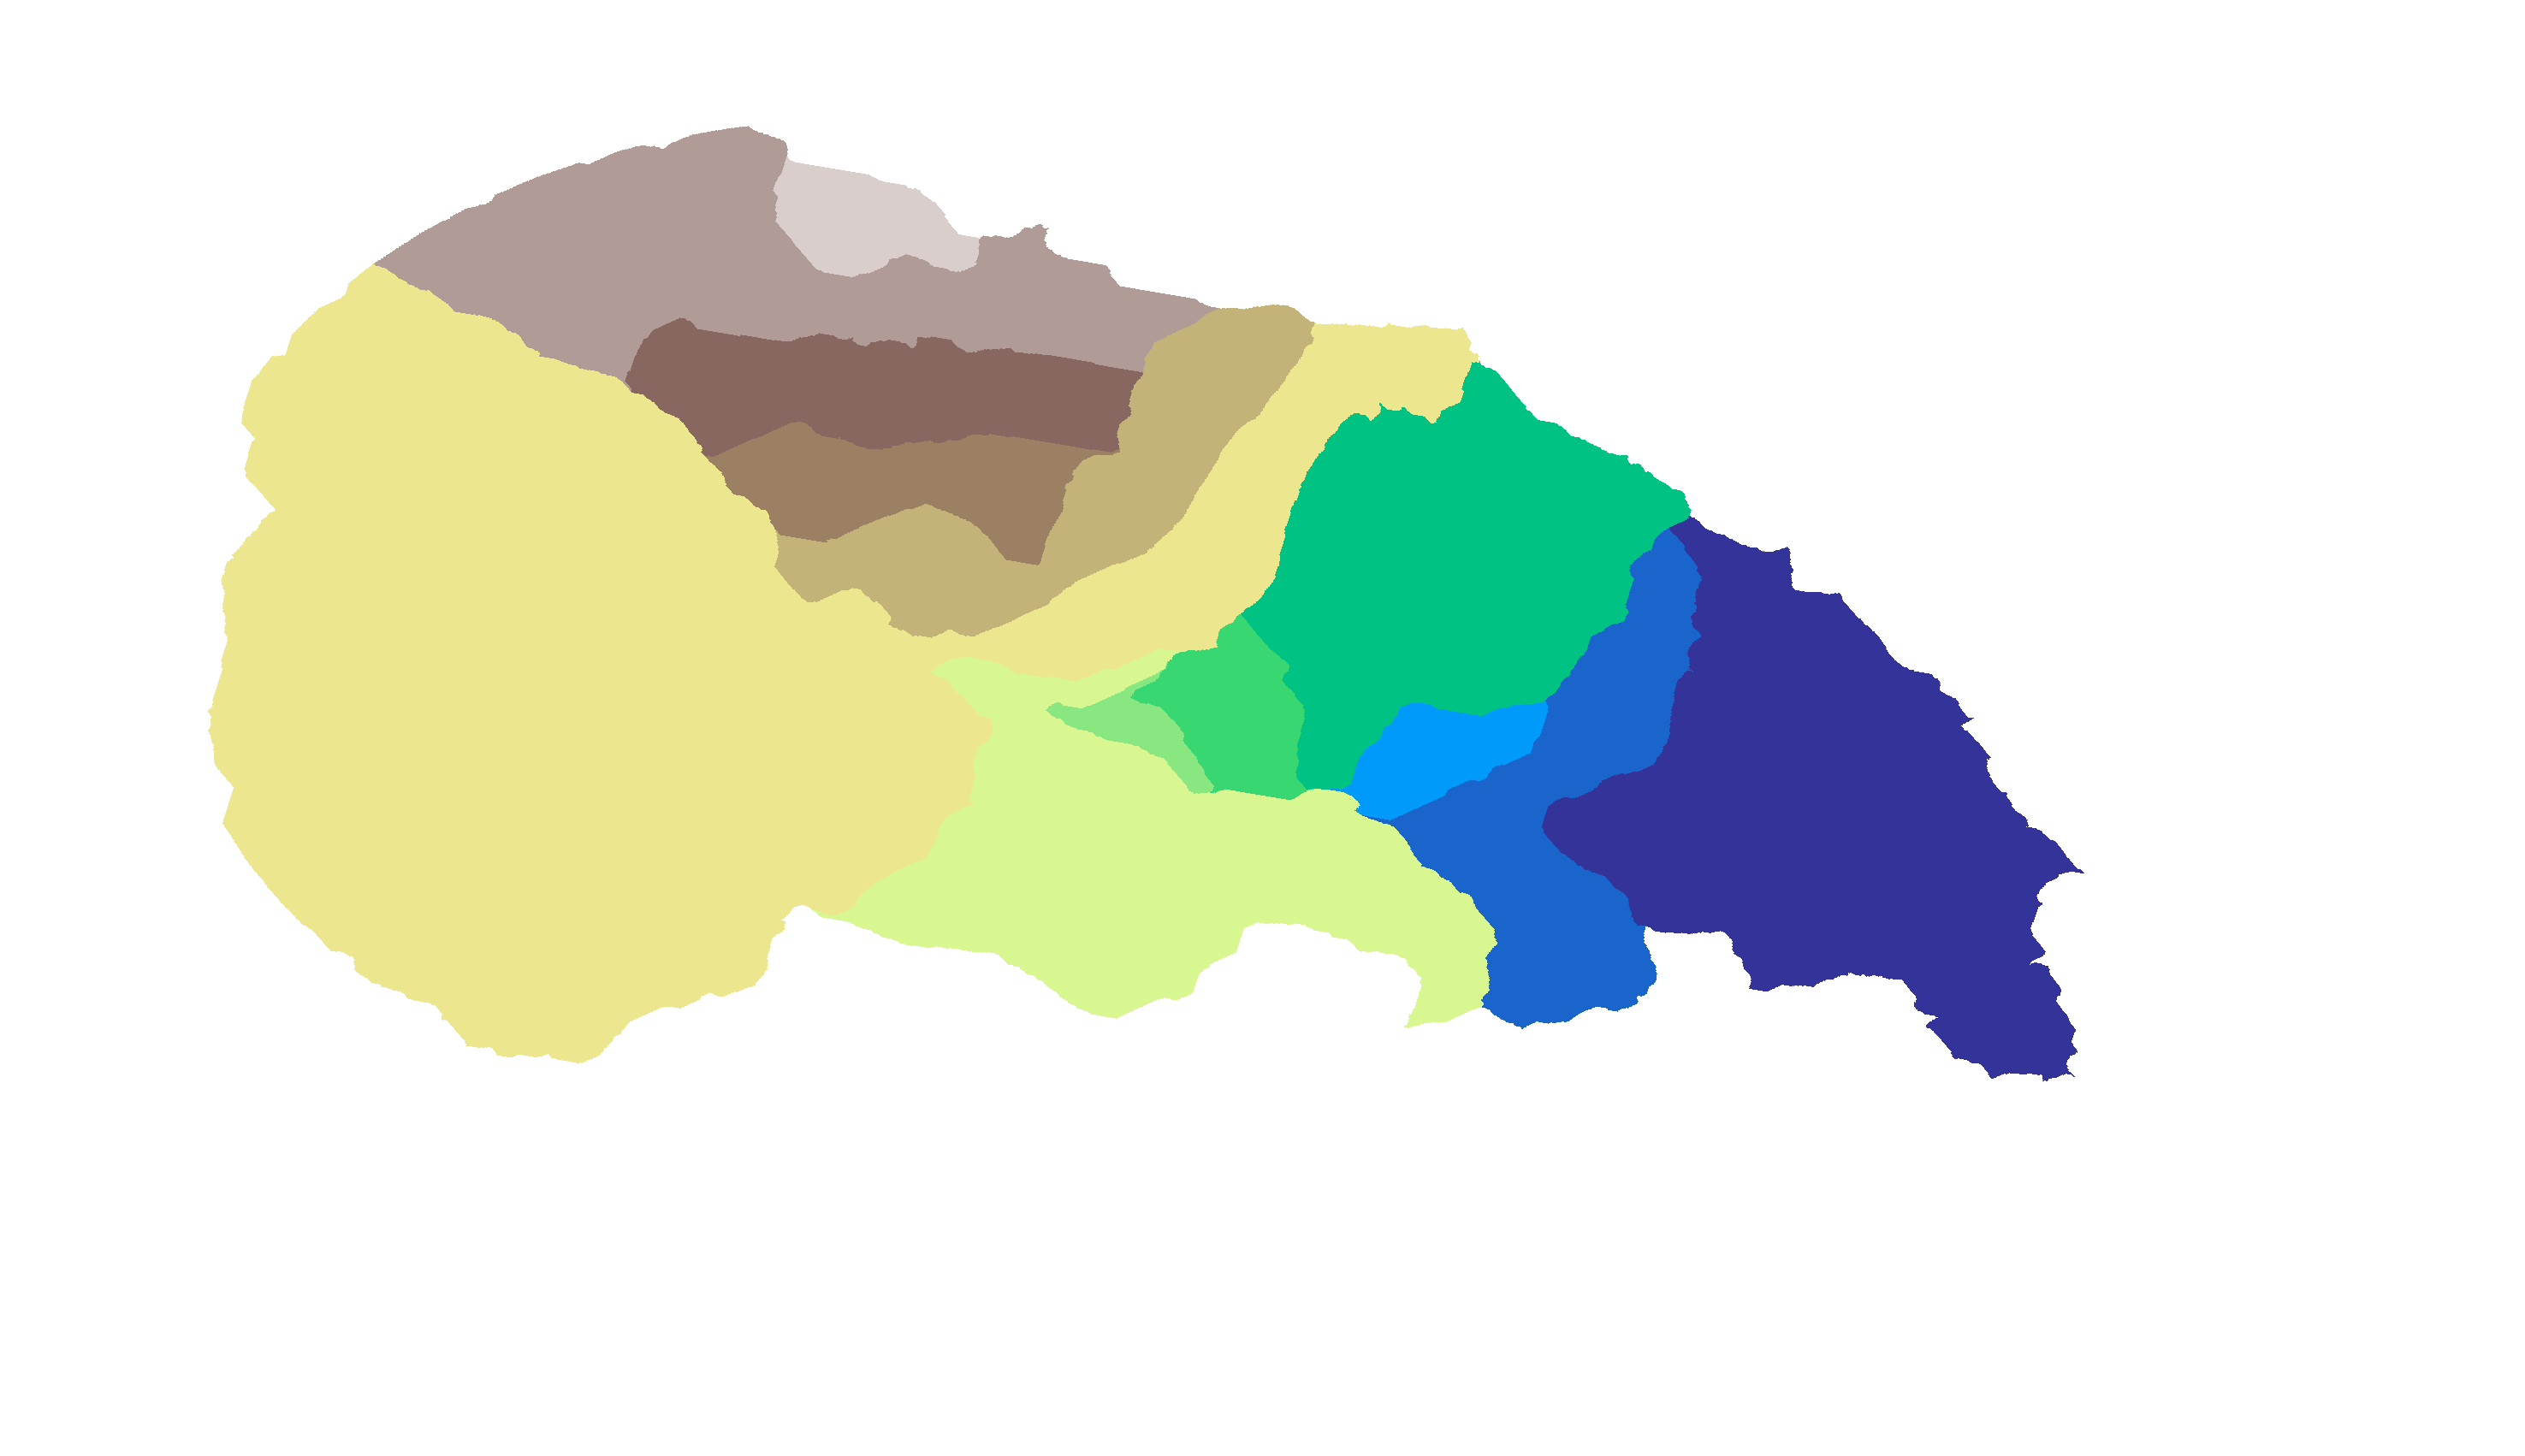

In [32]:
demDerived_reaches_split_data = generate_folium_vector_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_reaches_split_'+branch_to_look+'.gpkg'),
    '#0000FFFF','#0000FF00')

gw_catchments_reaches = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_'+branch_to_look+'.tif'))

gw_catchments_reaches_data = generate_folium_vector_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_'+branch_to_look+'.gpkg'),
    '#00FF00FF','#00FF0000')

gw_catchments_reaches_map = folium.Map(location=gw_catchments_reaches["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(demDerived_reaches_split_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="demDerived_reaches_split_data").add_to(gw_catchments_reaches_map)
folium.GeoJson(gw_catchments_reaches_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="gw_catchments_reaches_data").add_to(gw_catchments_reaches_map)
folium.raster_layers.ImageOverlay(
    name='gw_catchments_reaches',
    image=gw_catchments_reaches["array"],
    bounds=gw_catchments_reaches["bounds"]
).add_to(gw_catchments_reaches_map)
folium.LayerControl().add_to(gw_catchments_reaches_map)
gw_catchments_reaches_map

In [ ]:
### THIS IS WHERE I SHOULD TRIM WATERSHEDS!!!

In [ ]:
##### DEV Above

 ########################################################################## 
 Process catchments and model streams 02020005 3246000011
 ##########################################################################  




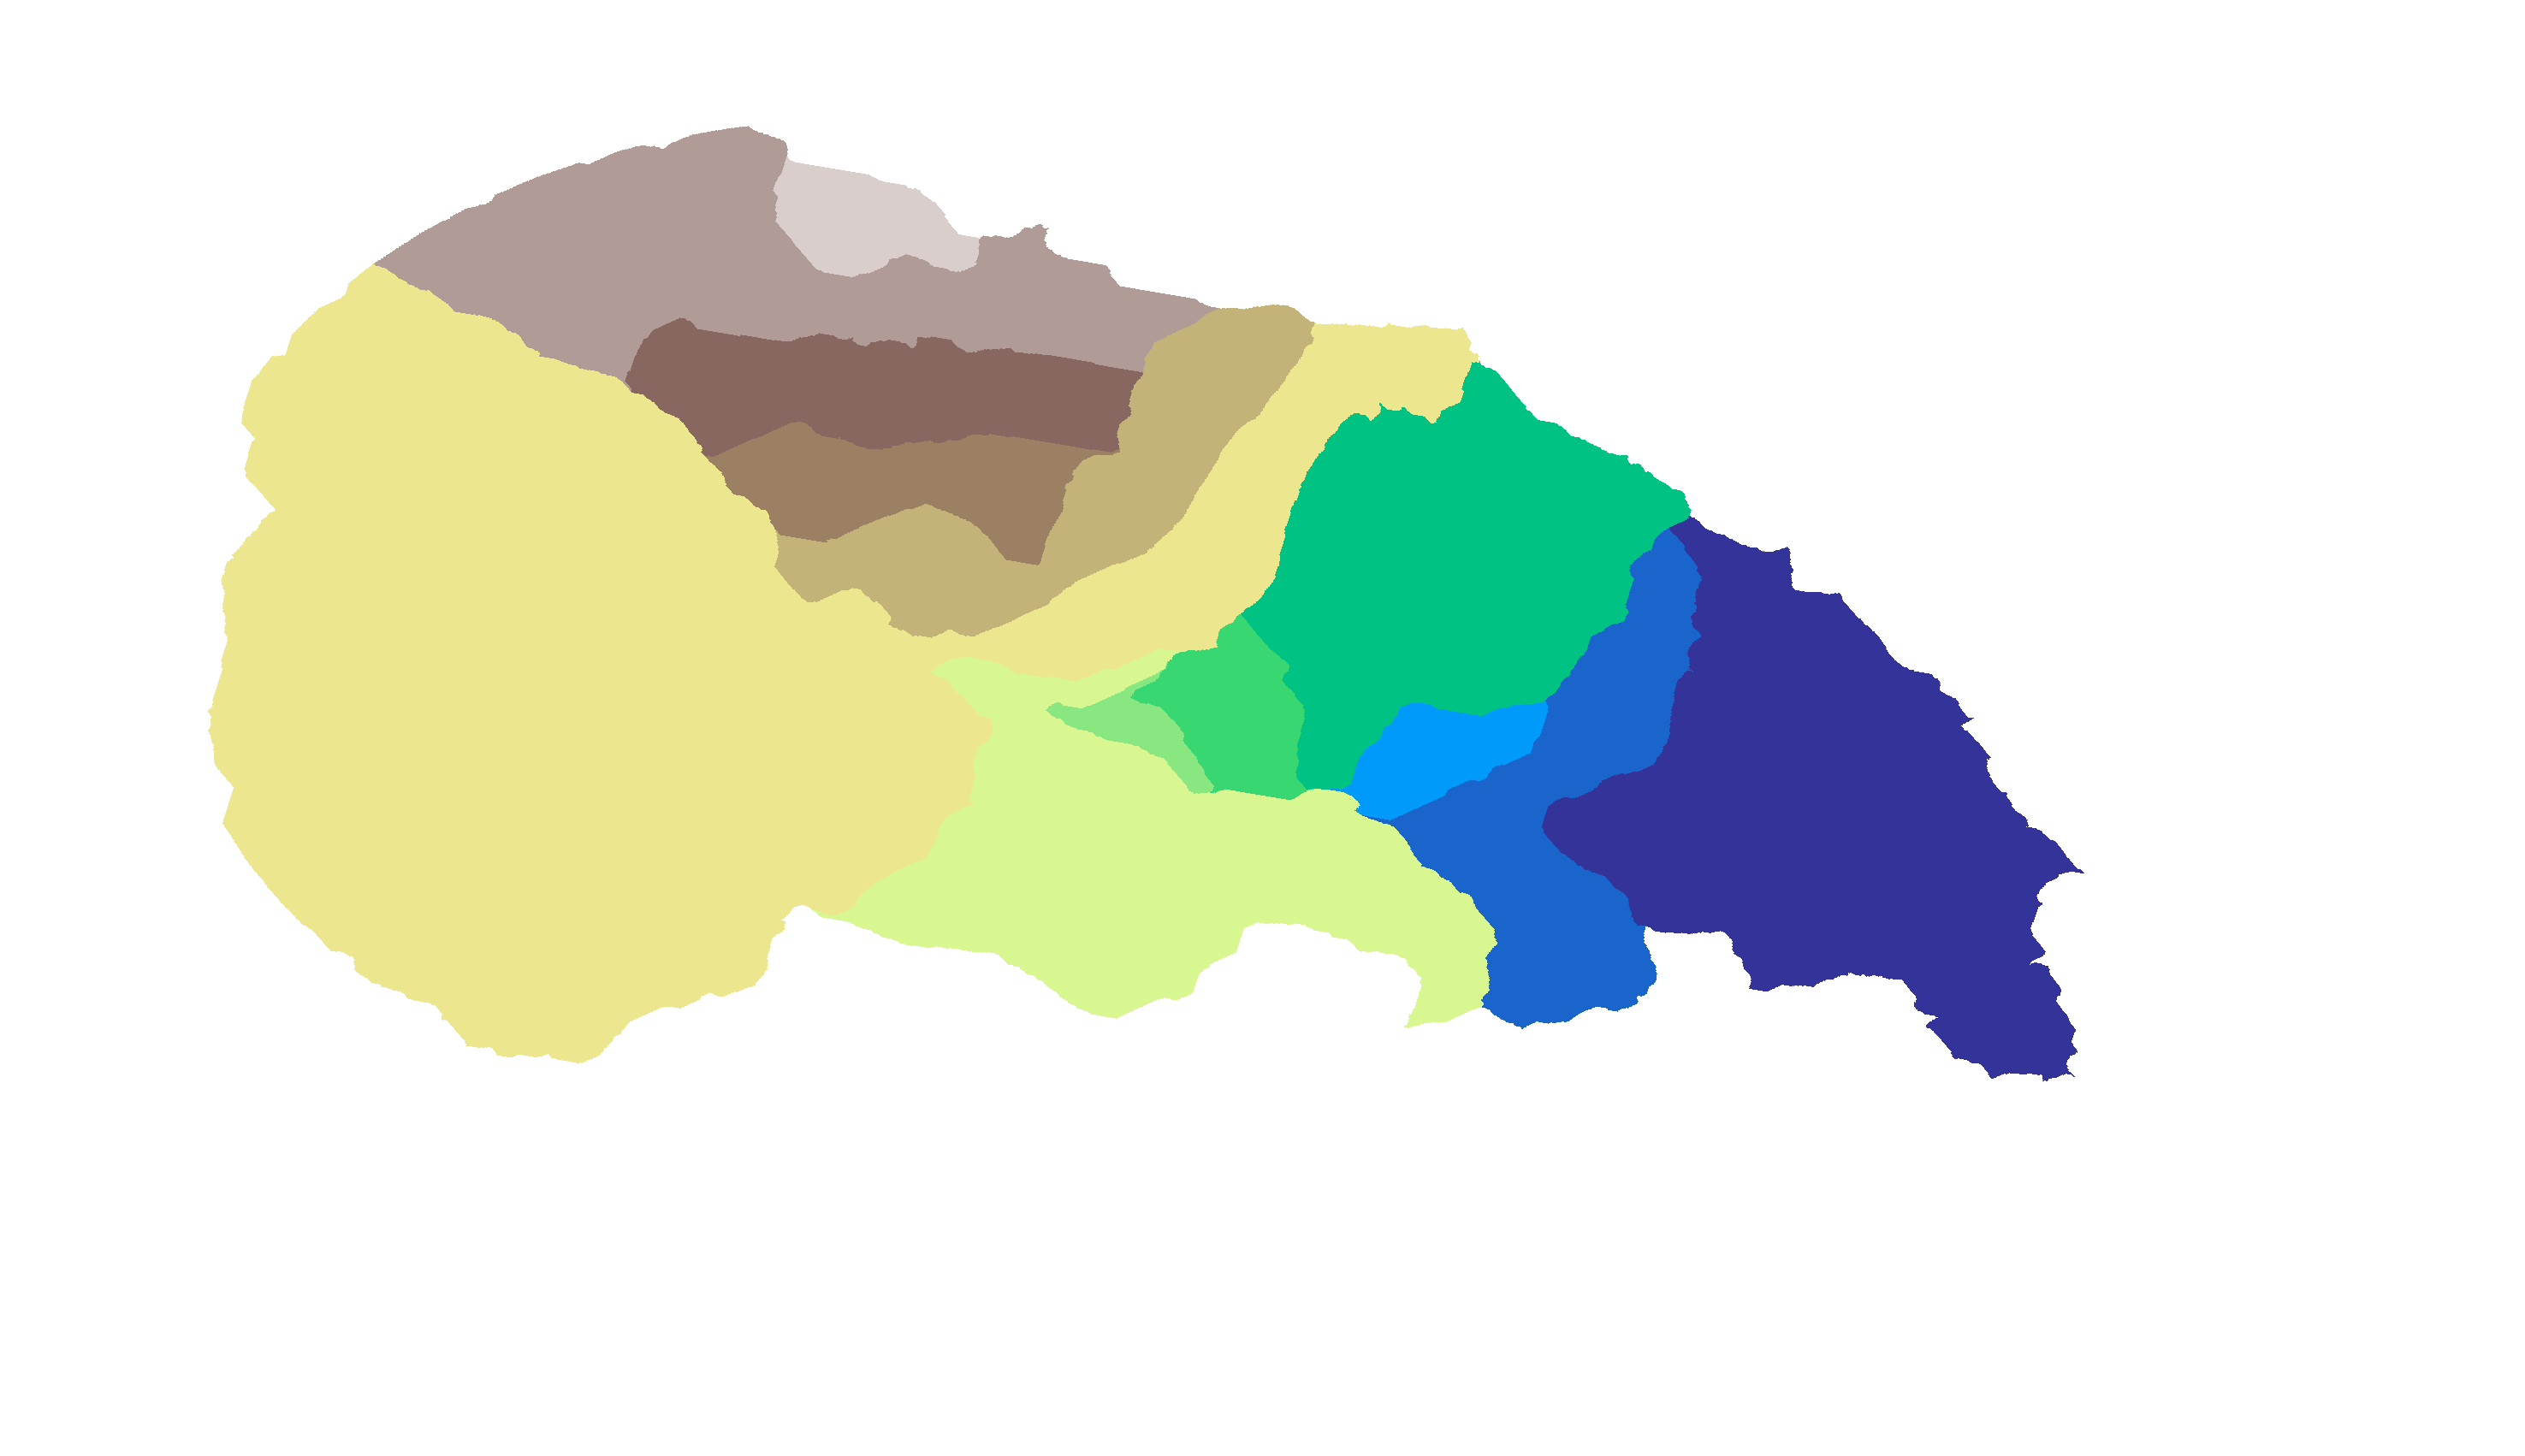

In [36]:
#$srcDir/filter_catchments_and_add_attributes.py 
#-i $outputCurrentBranchDataDir/gw_catchments_reaches_$current_branch_id.gpkg 
#-f $outputCurrentBranchDataDir/demDerived_reaches_split_$current_branch_id.gpkg 
#-c $outputCurrentBranchDataDir/gw_catchments_reaches_filtered_addedAttributes_$current_branch_id.gpkg 
#-o $outputCurrentBranchDataDir/demDerived_reaches_split_filtered_$current_branch_id.gpkg 
#-w $outputHucDataDir/wbd8_clp.gpkg 
#-u $hucNumber 
#-s $dropLowStreamOrders
print(' ########################################################################## \n',
      f'Process catchments and model streams {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

gw_catchments_reaches_data = generate_folium_vector_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_'+branch_to_look+'.gpkg'),
    '#00FF00FF','#00FF0000')

demDerived_reaches_split_data = generate_folium_vector_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_reaches_split_'+branch_to_look+'.gpkg'),
    '#00FF00FF','#00FF0000')

#gw_catchments_reaches_filtered_addedAttributes_data = generate_folium_vector_data(
#    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_filtered_addedAttributes_'+branch_to_look+'.gpkg'),
#    '#00FF00FF','#00FF0000')

#demDerived_reaches_split_filtered_data = generate_folium_vector_data(
#    os.path.join(root_folder,watershed,'branches',branch_to_look,'demDerived_reaches_split_filtered_'+branch_to_look+'.gpkg'),
#    '#00FF00FF','#00FF0000')

wbd8_clp_data = generate_folium_vector_data(
    os.path.join(root_folder,watershed,'wbd8_clp.gpkg'),
    '#00FF00FF','#00FF0000')

gw_catchments_reaches_map = folium.Map(location=gw_catchments_reaches["center"], zoom_start=9,tiles='Stamen Terrain')
folium.GeoJson(gw_catchments_reaches_data,
               style_function=lambda feature: {
                   'fillColor': feature['properties']['fill_RGBA'],
                   'color' : feature['properties']['Outline_RGBA'],
                   'weight' : 1,'fillOpacity' : 0.5},
               name="gw_catchments_reaches_data").add_to(gw_catchments_reaches_map)
folium.raster_layers.ImageOverlay(
    name='gw_catchments_reaches',
    image=gw_catchments_reaches["array"],
    bounds=gw_catchments_reaches["bounds"]
).add_to(gw_catchments_reaches_map)
folium.LayerControl().add_to(gw_catchments_reaches_map)
gw_catchments_reaches_map

In [39]:
print(' ########################################################################## \n',
      f'Rasterize filtered catchments {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

gw_catchments_reaches_filtered_addedAttributes_ras = generate_folium_raster_data(
    os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_filtered_addedAttributes_'+branch_to_look+'.tif'))

# gw_catchments_reaches_filtered_addedAttributes_data = generate_folium_vector_data(
#     os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_filtered_addedAttributes_'+branch_to_look+'.gpkg'),
#     '#00FF00FF','#00FF0000')

gw_catchments_reaches_map = folium.Map(location=gw_catchments_reaches_filtered_addedAttributes_ras["center"], zoom_start=9,tiles='Stamen Terrain')
# folium.GeoJson(gw_catchments_reaches_filtered_addedAttributes_data,
#                style_function=lambda feature: {
#                    'fillColor': feature['properties']['fill_RGBA'],
#                    'color' : feature['properties']['Outline_RGBA'],
#                    'weight' : 1,'fillOpacity' : 0.5},
#                name="gw_catchments_reaches_filtered_addedAttributes_data").add_to(gw_catchments_reaches_map)
folium.raster_layers.ImageOverlay(
    name='gw_catchments_reaches_filtered_addedAttributes_ras',
    image=gw_catchments_reaches_filtered_addedAttributes_ras["array"],
    bounds=gw_catchments_reaches_filtered_addedAttributes_ras["bounds"]
).add_to(gw_catchments_reaches_map)
folium.LayerControl().add_to(gw_catchments_reaches_map)
gw_catchments_reaches_map

 ########################################################################## 
 Rasterize filtered catchments 02020005 3246000011
 ##########################################################################  



ERROR 4: /data/outputs/jimjam_test/02020005/branches/3246000011/gw_catchments_reaches_filtered_addedAttributes_3246000011.tif: No such file or directory


AttributeError: 'NoneType' object has no attribute 'GetProjection'

In [ ]:
print(' ########################################################################## \n',
      f'Mask to slopes to catchments {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

slopes_d8_meters = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'slopes_d8_dem_meters_'+branch_to_look+'.tif'))
gw_catchments_reaches_filtered_addedAttributes = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'gw_catchments_reaches_filtered_addedAttributes_'+branch_to_look+'.tif'))
slopes_d8_dem_meters_masked = generate_folium_raster_data(os.path.join(root_folder,watershed,'branches',branch_to_look,'slopes_d8_dem_meters_masked_'+branch_to_look+'.tif'))

slopes_d8_dem_meters_masked_map = folium.Map(location=slopes_d8_dem_meters_masked["center"], zoom_start=9,tiles='Stamen Terrain')
folium.raster_layers.ImageOverlay(
    name='slopes_d8_meters',
    image=slopes_d8_meters["array"],
    bounds=slopes_d8_meters["bounds"]
).add_to(slopes_d8_dem_meters_masked_map)
folium.raster_layers.ImageOverlay(
    name='gw_catchments_reaches_filtered_addedAttributes',
    image=gw_catchments_reaches_filtered_addedAttributes["array"],
    bounds=gw_catchments_reaches_filtered_addedAttributes["bounds"]
).add_to(slopes_d8_dem_meters_masked_map)
folium.raster_layers.ImageOverlay(
    name='slopes_d8_dem_meters_masked',
    image=slopes_d8_dem_meters_masked["array"],
    bounds=slopes_d8_dem_meters_masked["bounds"]
).add_to(slopes_d8_dem_meters_masked_map)
folium.LayerControl().add_to(slopes_d8_dem_meters_masked_map)
slopes_d8_dem_meters_masked_map

In [ ]:
#$srcDir/make_stages_and_catchlist.py 
#-f $outputCurrentBranchDataDir/demDerived_reaches_split_filtered_$current_branch_id.gpkg -c $outputCurrentBranchDataDir/gw_catchments_reaches_filtered_addedAttributes_$current_branch_id.gpkg -s $outputCurrentBranchDataDir/stage_$current_branch_id.txt -a $outputCurrentBranchDataDir/catch_list_$current_branch_id.txt -m $stage_min_meters -i $stage_interval_meters -t $stage_max_meters
Tcount
print(' ########################################################################## \n',
      f'Generate Catchment List and Stage List Files {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')
## MAKE CATCHMENT AND STAGE FILES ##
echo -e $startDiv"$hucNumber $current_branch_id"$stopDiv
date -u
Tstart
$srcDir/make_stages_and_catchlist.py -f $outputCurrentBranchDataDir/demDerived_reaches_split_filtered_$current_branch_id.gpkg -c $outputCurrentBranchDataDir/gw_catchments_reaches_filtered_addedAttributes_$current_branch_id.gpkg -s $outputCurrentBranchDataDir/stage_$current_branch_id.txt -a $outputCurrentBranchDataDir/catch_list_$current_branch_id.txt -m $stage_min_meters -i $stage_interval_meters -t $stage_max_meters
Tcount


In [ ]:
gdal_calc.py --quiet --type=Float32 --overwrite --co "COMPRESS=LZW" --co "BIGTIFF=YES" --co "TILED=YES" -A $outputCurrentBranchDataDir/rem_zeroed_masked_$current_branch_id.tif -B $outputCurrentBranchDataDir/LandSea_subset_$current_node_id.tif --calc="(A*B)" --NoDataValue=$ndv --outfile=$outputCurrentBranchDataDir/"rem_zeroed_masked_$current_branch_id.tif"
Tcount
print(' ########################################################################## \n',
      f'Additional masking to REM raster to remove ocean/Glake areas {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')
echo -e $startDiv" $hucNumber $current_branch_id"$stopDiv
date -u
Tstart
[ -f $outputCurrentBranchDataDir/LandSea_subset.tif ] && \
gdal_calc.py --quiet --type=Float32 --overwrite --co "COMPRESS=LZW" --co "BIGTIFF=YES" --co "TILED=YES" -A $outputCurrentBranchDataDir/rem_zeroed_masked_$current_branch_id.tif -B $outputCurrentBranchDataDir/LandSea_subset_$current_node_id.tif --calc="(A*B)" --NoDataValue=$ndv --outfile=$outputCurrentBranchDataDir/"rem_zeroed_masked_$current_branch_id.tif"
Tcount

In [ ]:
#$taudemDir/catchhydrogeo 
#-hand $outputCurrentBranchDataDir/rem_zeroed_masked_$current_branch_id.tif 
#-catch $outputCurrentBranchDataDir/gw_catchments_reaches_filtered_addedAttributes_$current_branch_id.tif -catchlist $outputCurrentBranchDataDir/catch_list_$current_branch_id.txt -slp $outputCurrentBranchDataDir/slopes_d8_dem_meters_masked_$current_branch_id.tif -h $outputCurrentBranchDataDir/stage_$current_branch_id.txt -table $outputCurrentBranchDataDir/src_base_$current_branch_id.csv
print(' ########################################################################## \n',
      f'Sample reach averaged parameters {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')


In [ ]:
## FINALIZE CATCHMENTS AND MODEL STREAMS ##
echo -e $startDiv"Finalize catchments and model streams $hucNumber $current_branch_id"$stopDiv
date -u
Tstart
python3 -m memory_profiler $srcDir/add_crosswalk.py -d $outputCurrentBranchDataDir/gw_catchments_reaches_filtered_addedAttributes_$current_branch_id.gpkg -a $outputCurrentBranchDataDir/demDerived_reaches_split_filtered_$current_branch_id.gpkg -s $outputCurrentBranchDataDir/src_base_$current_branch_id.csv -l $outputCurrentBranchDataDir/gw_catchments_reaches_filtered_addedAttributes_crosswalked_$current_branch_id.gpkg -f $outputCurrentBranchDataDir/demDerived_reaches_split_filtered_addedAttributes_crosswalked_$current_branch_id.gpkg -r $outputCurrentBranchDataDir/src_full_crosswalked_$current_branch_id.csv -j $outputCurrentBranchDataDir/src_$current_branch_id.json -x $outputCurrentBranchDataDir/crosswalk_table_$current_branch_id.csv -t $outputCurrentBranchDataDir/hydroTable_$current_branch_id.csv -w $outputHucDataDir/wbd8_clp.gpkg -b $outputCurrentBranchDataDir/nwm_subset_streams_levelPaths_$current_branch_id.gpkg -y $outputCurrentBranchDataDir/nwm_catchments_proj_subset.tif -m $manning_n -z $outputCurrentBranchDataDir/nwm_catchments_proj_subset_levelPaths_$current_branch_id.gpkg -p $extent -k $outputCurrentBranchDataDir/small_segments_$current_branch_id.csv
print(' ########################################################################## \n',
      f'Finalize catchments and model streams {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')

In [ ]:
## USGS CROSSWALK ##
if [ -f $outputHucDataDir/usgs_subset_gages.gpkg ]; then
print(' ########################################################################## \n',
      f'USGS Crosswalk {watershed} {branch_to_look}\n',
      '########################################################################## ',
      '\n')
    echo -e $startDiv"USGS Crosswalk $hucNumber $current_branch_id"$stopDiv
    date -u
    Tstart
    python3 $srcDir/usgs_gage_crosswalk.py -gages $outputHucDataDir/usgs_subset_gages.gpkg -flows $outputCurrentBranchDataDir/demDerived_reaches_split_filtered_$current_branch_id.gpkg -cat $outputCurrentBranchDataDir/gw_catchments_reaches_filtered_addedAttributes_crosswalked_$current_branch_id.gpkg -dem $outputCurrentBranchDataDir/dem_meters_$current_branch_id.tif -dem_adj $outputCurrentBranchDataDir/dem_thalwegCond_$current_branch_id.tif -outtable $outputCurrentBranchDataDir/usgs_elev_table.csv -b $current_branch_id
    Tcount
fi

In [ ]:
print(' ########################################################################## \n',
     f'End Processing {watershed} {branch_to_look}, great success?\n',
     '##########################################################################')